In [ ]:
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy
import scipy.cluster
import sklearn
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.mixture import GaussianMixture

In [ ]:
!python --version

Python 3.7.13


In [ ]:
!echo $PYTHONPATH

/env/python


# Setup Situation 1

## Instructions

You work at a local jewelry store named *Uncle Steve's Diamonds*. You started as a janitor, but you’ve recently been promoted to senior data analyst! Congratulations.

Uncle Steve, the store's owner, needs to better understand the store's customers. In particular, he wants to know what kind of customers shop at the store. He wants to know the main types of *customer personas*. Once he knows these, he will contemplate ways to better market to each persona, better satisfy each persona, better cater to each persona, increase the loyalty of each persona, etc. But first, he must know the personas.

You want to help Uncle Steve. Using sneaky magic (and the help of Environics), you've collected four useful features for a subset of the customers: age, income, spending score (i.e., a score based on how much they’ve spent at the store in total), and savings (i.e., how much money they have in their personal bank account). 

**Your tasks**

1. Pick a clustering algorithm (the [`sklearn.cluster`](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.cluster) module has many good choices, including [`KMeans`](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans), [`DBSCAN`](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html#sklearn.cluster.DBSCAN), and [`AgglomerativeClustering`](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html#sklearn.cluster.AgglomerativeClustering) (aka Hierarchical)). (Note that another popular implementation of the hierarchical algorithm can be found in SciPy's [`scipy.cluster.hierarchy.linkage`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.linkage.html).) Don't spend a lot of time thinking about which algorithm to choose - just pick one. Cluster the customers as best as you can, within reason. That is, try different feature preprocessing steps, hyperparameter values, and/or distance metrics. You don't need to try every posssible combination, but try a few at least. Measure how good each  model configuration is by calculating an internal validation metric (e.g., [`calinski_harabasz_score`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.calinski_harabasz_score.html) or [`silhouette_score`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html#sklearn.metrics.silhouette_score)).
2. You have some doubts - you're not sure if the algorithm you chose in part 1 is the best algorithm for this dataset/problem. Neither is Uncle Steve. So, choose a different algorithm (any!) and do it all again.
3. Which clustering algorithm is "better" in this case? Think about charateristics of the algorithm like quality of results, ease of use, speed, interpretability, etc. Choose a "winner" and justify to Uncle Steve.
4. Interpret the clusters of the winning model. That is, describe, in words, a *persona* that accurately depicts each cluster. Use statistics (e.g., cluster means/distributions), examples (e.g., exemplar instances from each cluster), and/or visualizations (e.g., relative importance plots, snakeplots) to get started. Human judgement and creativity will be necessary. This is where it all comes together. Be descriptive and *help Uncle Steve understand his customers better*. Please!

## 1.0: Load data 

In [ ]:
df1 = pd.read_csv("https://drive.google.com/uc?export=download&id=1thHDCwQK3GijytoSSZNekAsItN_FGHtm")
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 505 entries, 0 to 504
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Age            505 non-null    int64  
 1   Income         505 non-null    int64  
 2   SpendingScore  505 non-null    float64
 3   Savings        505 non-null    float64
dtypes: float64(2), int64(2)
memory usage: 15.9 KB


In [ ]:
df1.describe()

,Age,Income,SpendingScore,Savings
count,505.000000,505.000000,505.000000,505.000000
mean,59.019802,75513.291089,0.505083,11862.455867
std,24.140043,35992.922184,0.259634,4949.229253
min,17.000000,12000.000000,0.000000,0.000000
25%,34.000000,34529.000000,0.304792,6828.709702
50%,59.000000,75078.000000,0.368215,14209.932802
75%,85.000000,107100.000000,0.768279,16047.268331
max,97.000000,142000.000000,1.000000,20000.000000


In [ ]:
#I just want to see what the data looks like. I'm curious.
df1.head()

,Age,Income,SpendingScore,Savings
0,58,77769,0.791329,6559.829923
1,59,81799,0.791082,5417.661426
2,62,74751,0.702657,9258.992965
3,59,74373,0.765680,7346.334504
4,87,17760,0.348778,16869.507130


In [ ]:
#I scale all my data (because all 4 features are highly disparate). This means I need to use inverse_scaler to view the original data
scaler = StandardScaler()
features = ['Age', 'Income', 'SpendingScore', 'Savings']
df1[features] = scaler.fit_transform(df1[features])

In [ ]:
#I want to see the results of the standardization
df1.head(10)


,Age,Income,SpendingScore,Savings
0,-0.042287,0.062733,1.103593,-1.072467
1,-0.000821,0.174811,1.102641,-1.303473
2,0.123577,-0.021200,0.761727,-0.526556
3,-0.000821,-0.031712,1.004705,-0.913395
4,1.160228,-1.606165,-0.602619,1.012686
5,-1.244802,1.559204,1.318359,-1.684141
6,-0.208151,0.027441,1.079955,-1.007937
7,1.160228,-0.915567,-0.577512,1.258782
8,0.994363,-1.143838,-0.695375,0.590763
9,1.035829,-1.329920,-0.532121,1.216971


## 1.1: Clustering Algorithm #1 - Kmeans

In [ ]:
#I run the k-means algorithm. My arguments mean I'm looking for 5 clusters and the random seed is 666 (for reproducibility)
k_means = KMeans(n_clusters=5, random_state=666)
k_means.fit(df1)

KMeans(n_clusters=5, random_state=666)

In [ ]:
# This algorithm does creates a new column and assigns a number to each row. I want to see that list of numbers.
k_means.labels_

array([1, 1, 1, 1, 2, 4, 1, 2, 2, 2, 3, 0, 0, 0, 1, 3, 1, 2, 2, 3, 0, 3,
       1, 2, 3, 4, 4, 1, 2, 1, 1, 1, 2, 1, 0, 1, 2, 1, 0, 0, 1, 2, 4, 1,
       1, 4, 3, 4, 0, 1, 2, 0, 4, 2, 1, 2, 0, 2, 2, 2, 2, 2, 2, 1, 1, 1,
       2, 4, 4, 1, 1, 0, 2, 2, 0, 1, 0, 1, 1, 4, 1, 3, 1, 2, 2, 0, 0, 1,
       1, 1, 1, 1, 4, 2, 1, 4, 0, 1, 1, 0, 0, 4, 0, 4, 0, 2, 2, 0, 0, 1,
       2, 0, 1, 0, 0, 0, 1, 0, 4, 2, 0, 2, 2, 2, 0, 3, 1, 2, 1, 1, 0, 1,
       0, 1, 4, 2, 3, 4, 1, 0, 2, 1, 1, 4, 1, 4, 1, 3, 1, 2, 1, 0, 2, 1,
       2, 3, 0, 1, 2, 1, 0, 2, 1, 0, 2, 0, 2, 1, 0, 1, 2, 1, 0, 1, 2, 1,
       1, 2, 2, 2, 1, 1, 0, 4, 4, 2, 0, 1, 1, 1, 0, 2, 1, 1, 1, 2, 4, 0,
       2, 2, 2, 0, 1, 0, 1, 0, 1, 2, 4, 1, 2, 2, 2, 2, 1, 2, 0, 4, 0, 2,
       1, 1, 0, 2, 0, 4, 0, 1, 1, 2, 1, 1, 2, 1, 1, 1, 0, 1, 0, 0, 4, 1,
       1, 1, 3, 1, 0, 2, 4, 4, 4, 2, 1, 0, 2, 2, 0, 0, 1, 1, 3, 1, 1, 2,
       1, 2, 0, 4, 1, 0, 2, 1, 2, 2, 0, 1, 2, 2, 1, 1, 2, 0, 0, 3, 0, 2,
       2, 0, 3, 2, 2, 4, 1, 0, 0, 1, 0, 2, 2, 0, 1,

In [ ]:
#I want to see the centroids. The list has 5 items (one for each centroid) with 4 coordinates (since this is four-dimensional)
k_means.cluster_centers_


array([[-1.08815238,  0.82744102, -0.75240648,  0.6270464 ],
       [ 0.03879611, -0.08524639,  1.02721559, -1.00569483],
       [ 1.19238486, -1.32510593, -0.67963841,  0.97016358],
       [ 1.11876151,  1.23565419, -1.68367042,  0.59588052],
       [-1.44466803,  1.46050665,  1.51057952, -1.57249636]])

In [ ]:
df1.describe()

,Age,Income,SpendingScore,Savings
count,5.050000e+02,5.050000e+02,5.050000e+02,5.050000e+02
mean,6.683323e-17,-2.814031e-17,-2.814031e-16,-3.939643e-16
std,1.000992e+00,1.000992e+00,1.000992e+00,1.000992e+00
min,-1.742394e+00,-1.766355e+00,-1.947295e+00,-2.399206e+00
25%,-1.037472e+00,-1.139805e+00,-7.722011e-01,-1.018085e+00
50%,-8.211094e-04,-1.210579e-02,-5.276784e-01,4.747819e-01
75%,1.077295e+00,8.784513e-01,1.014725e+00,8.463867e-01
max,1.574888e+00,1.849048e+00,1.908103e+00,1.645835e+00


In [ ]:
# K-Means minimizes inertia. It is a measure of how coherent the clusters are internally.
k_means.inertia_

66.51111374859082

In [ ]:
# This measures the inter-cluster distance. The range is -1 to 1, higher numbers are better.
silhouette_score(df1, k_means.labels_)

0.8048976287755765

In [ ]:
# This measures intra cluster distance. Range is 0 to infinity, higher numbers are better.
sklearn.metrics.calinski_harabasz_score(df1, k_means.labels_)

3671.358018517615

In [ ]:
# These are my centroid coordinates using inverse transform
scaler.inverse_transform(k_means.cluster_centers_)

array([[3.27777778e+01, 1.05265810e+05, 3.09926130e-01, 1.49627781e+04],
       [5.99554140e+01, 7.24480637e+04, 7.71518368e-01, 6.88997219e+03],
       [8.77755102e+01, 2.78661020e+04, 3.28800461e-01, 1.66592614e+04],
       [8.60000000e+01, 1.19944040e+05, 6.83780993e-02, 1.48086838e+04],
       [2.41800000e+01, 1.28029120e+05, 8.96891640e-01, 4.08752031e+03]])

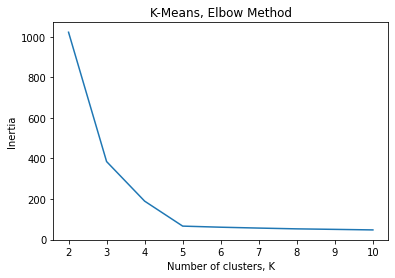

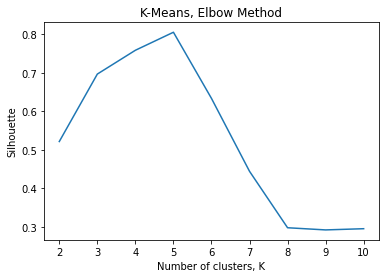

In [ ]:
# Testing various K values against Inertia and Silhouette Coefficient
# from 2 to 10. We see inertia hitting its low at 5 and silhouette score
# peaking at 5.
inertias = {}
silhouettes = {}
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=666).fit(df1)
    inertias[k] = kmeans.inertia_
    silhouettes[k] = silhouette_score(df1, kmeans.labels_, metric='euclidean')
    

plt.figure();
plt.plot(list(inertias.keys()), list(inertias.values()));
plt.title('K-Means, Elbow Method')
plt.xlabel("Number of clusters, K");
plt.ylabel("Inertia");


plt.figure();
plt.plot(list(silhouettes.keys()), list(silhouettes.values()));
plt.title('K-Means, Elbow Method')
plt.xlabel("Number of clusters, K");
plt.ylabel("Silhouette");

## 1.2: Clustering Algorithm #2 - Heirachical

In [ ]:
agg = AgglomerativeClustering(n_clusters=5, affinity='euclidean', linkage='ward')
agg.fit(df1)

AgglomerativeClustering(n_clusters=5)

In [ ]:
agg.labels_

array([1, 1, 1, 1, 0, 3, 1, 0, 0, 0, 4, 2, 2, 2, 1, 4, 1, 0, 0, 4, 2, 4,
       1, 0, 4, 3, 3, 1, 0, 1, 1, 1, 0, 1, 2, 1, 0, 1, 2, 2, 1, 0, 3, 1,
       1, 3, 4, 3, 2, 1, 0, 2, 3, 0, 1, 0, 2, 0, 0, 0, 0, 0, 0, 1, 1, 1,
       0, 3, 3, 1, 1, 2, 0, 0, 2, 1, 2, 1, 1, 3, 1, 4, 1, 0, 0, 2, 2, 1,
       1, 1, 1, 1, 3, 0, 1, 3, 2, 1, 1, 2, 2, 3, 2, 3, 2, 0, 0, 2, 2, 1,
       0, 2, 1, 2, 2, 2, 1, 2, 3, 0, 2, 0, 0, 0, 2, 4, 1, 0, 1, 1, 2, 1,
       2, 1, 3, 0, 4, 3, 1, 2, 0, 1, 1, 3, 1, 3, 1, 4, 1, 0, 1, 2, 0, 1,
       0, 4, 2, 1, 0, 1, 2, 0, 1, 2, 0, 2, 0, 1, 2, 1, 0, 1, 2, 1, 0, 1,
       1, 0, 0, 0, 1, 1, 2, 3, 3, 0, 2, 1, 1, 1, 2, 0, 1, 1, 1, 0, 3, 2,
       0, 0, 0, 2, 1, 2, 1, 2, 1, 0, 3, 1, 0, 0, 0, 0, 1, 0, 2, 3, 2, 0,
       1, 1, 2, 0, 2, 3, 2, 1, 1, 0, 1, 1, 0, 1, 1, 1, 2, 1, 2, 2, 3, 1,
       1, 1, 4, 1, 2, 0, 3, 3, 3, 0, 1, 2, 0, 0, 2, 2, 1, 1, 4, 1, 1, 0,
       1, 0, 2, 3, 1, 2, 0, 1, 0, 0, 2, 1, 0, 0, 1, 1, 0, 2, 2, 4, 2, 0,
       0, 2, 4, 0, 0, 3, 1, 2, 2, 1, 2, 0, 0, 2, 1,

In [ ]:
silhouette_score(df1, agg.labels_)

0.8048976287755765

In [ ]:
sklearn.metrics.calinski_harabasz_score(df1, agg.labels_)

3671.3580185176156

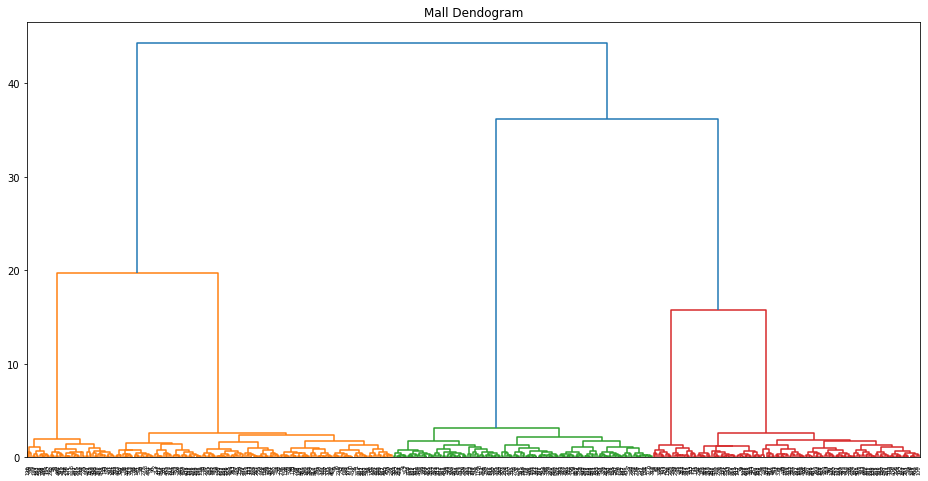

In [ ]:
# Plotting the Dendrogram with SciPy

aggl = scipy.cluster.hierarchy.linkage(df1, method='ward', metric='euclidean')

# Plot the dendogram
plt.figure(figsize=(16, 8));
plt.grid(False)
plt.title("Mall Dendogram");  
dend = scipy.cluster.hierarchy.dendrogram(aggl); 

## 1.3 Model Comparison

Both models performed very similarly to each other. The Silhouette Coefficient and the Calinsky-Harabasz Scores were identical for both experiments.

If I had to choose a winner based on factors like ease of use and interpretability. I would have to select the K-Means algorithm. The centroids in 4 dimensions still give me adequate means to select an "exemplar". The multideminsional nature of the subject makes it hard to visualize in the mind's eye, I can still draw certain assumptions of the clients in a way that takes into account more than 2 features.

The algorithm also ran very quickly and was easy to hyperparameter tune. Plotting the dendrogram takes time whereas K-Means was quicker to execute in terms of runtime. The tools provided me with all the insights I needed to know (inertia and silhouette) to make an educated choice on the number of groups that worked best for this situation.

## 1.4 Personas

Given that the Silhouette Score is high (High inter-cluster distance) and the Calisnky-Harabasz Score is high (high intra-cluster density), my method of creating the personas will use the centroid points to describe attributes. Seeing as the groups are well defined, this is a prudent assumption to make concerning customer segmentation.

##Cluster 1: The "About to make a mistake"
Age: 32.77
Income: 105,265
Spend: 0.3099
Savings: 14962.78

This person is doing just fine. They're young. They make a ton of money. They don't spend that much on jewelery, but you know from their savings account that they have a significant other and they're about to make a mistake. Let's sell them a ring worth having and make the next 2 decades of hell sting a little harder with this expensive reminder that they always had the option of being free...

##Cluster 2: The "Is that lipstick on your shirt?!"
Age: 59.95
Income: 72,448
Spend: 0.7715
Savings: 6,889.97

This person has been living with their mistake for more than 20 years now. Kids, the routine, the awful boss, the horrific traffic... The secretary gave you one too many smiles until you made a mistake. You got caught... Either you give everything away in alimony payments, or you can meet with some of our jewelers so that some of that value makes it back to your kids in the form of cash when they pawn it after you slip from this mortal coil.

##Cluster 3: The Disappointment
Age: 87.75
Income: 27,866
Spend: 0.3288
Savings: 16,659.26

You're still alive?! Hopefully your family still notices. The best we can offer you is a small trinket you can give to your grandchildren on their birthdays so they can feel like good people while it gathers dust atop some stand in their bedroom..."Who gave me this again?"

##Cluster 4: The Sugar-Daddy (Aka Ole'Regular)
Age: 86
Income: 119,944
Spend:0.6837
Savings: 14,808.68

Get over here you retired executive, sly-dog you! You're over the hill and you're on your way, but why not go out with a bang! We'll equip you with the finest jewels to keep the honeys coming, and maybe with some luck: You will too!

##Cluster 5: The Software Engineer 
Age: 24.18
Income: 128,029
Spend: 0.8969
Savings: 4,087.52

You did it nerd! You graduated top of your class in Software Engineering. Amazon came along and snatched you up! You're on the road to the upper class! With money, comes confidence! You finally got laid! Seeing as this is the first time you touched a woman, we'll make sure you keep her after you disappoint her with plenty of necklaces, rings, earrings, tiaras, you name it. We expect to see you every week and you too will be on your way to making a mistake! OHH YEAHHHH!


# Question 2: Uncle Steve's Credit Union

## Instructions

Uncle Steve has recently opened a new credit union in Kingston, named *Uncle Steve's Credit Union*. He plans to disrupt the local market by instaneously providing credit to customers.

The first step in Uncle Steve's master plan is to create a model to predict whether an application has *good risk* or *bad risk*. He has outsourced the creation of this model to you.

You are to create a classification model to predict whether a loan applicant has good risk or bad risk. You will use data  that Uncle Steve bought from another credit union (somewhere in Europe, he thinks?) that has around 6000 instances and a number of demographics features (e.g., `Sex`, `DateOfBirth`, `Married`), loan details (e.g., `Amount`, `Purpose`), credit history (e.g., number of loans), as well as an indicator (called `BadCredit` in the dataset) as to whether that person was a bad risk.


**Your tasks**

To examine the effects of the various ML stages, you are to create the model several times, each time adding more sophistication, and measuring how much the model improved (or not). In particular, you will:

0. Split the data in training and testing. Don't touch the testing data again, for any reason, until step 5. We are pretending that the testing data is "future, unseen data that our model won't see until production." I'm serious, don't touch it. I'm watching you!
1. Build a baseline model - no feature engineering, no feature selection, no hyperparameter tuning (just use the default settings), nothing fancy. (You may need to do some basic feature transformations, e.g., encoding of categorical features, or dropping of features you do not think will help or do not want to deal with yet.) Measure the performance using K-fold cross validation (recommended: [`sklearn.model_selection.cross_val_score`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html#sklearn.model_selection.cross_val_score)) on the training data. Use at least 5 folds, but more are better. Choose a [`scoring` parameter](https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter) (i.e., classification metric) that you feel is appropriate for this task. Don't use accuracy. Print the mean score of your model.
2. Add a bit of feature engineering. The [`sklearn.preprocessing`](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.preprocessing) module contains many useful transformations. Engineer at least three new features. They don't need to be especially ground-breaking or complicated. Dimensionality reduction techniques like [`sklearn.decomposition.PCA`](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) are fair game but not required. (If you do use dimensionality reduction techniques, it would only count as "one" new feature for the purposes of this assignment, even though I realize that PCA creates many new "features" (i.e., principal componentns).) Re-train your baseline model. Measure performance. Compare to step 1.
3. Add feature selection. The [`sklearn.feature_selection`](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.feature_selection) has some algorithms for you to choose from. After selecting features, re-train your model, measure performance, and compare to step 2.
4. Add hyperparameter tuning. Make reasonable choices and try to find the best (or at least, better) hyperparameters for your estimator and/or transformers. It's probably a good idea to stop using `cross_val_score` at this point and start using [`sklearn.model_selection.GridSearchCV`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html#sklearn.model_selection.GridSearchCV) as it is specifically built for this purpose and is more convienient to use. Measure performance and compare to step 3.
5. Finally, estimate how well your model will work in production. Use the testing data (our "future, unseen data") from step 0. Transform the data as appropriate (easy if you've built a pipeline, a little more difficult if not), use the model from step 4 to get predictions, and measure the performance. How well did we do? 

## 2.0: Load data and split

In [ ]:
# First, we'll read the provided labeled training data
df3 = pd.read_csv("https://drive.google.com/uc?export=download&id=1wOhyCnvGeY4jplxI8lZ-bbYN3zLtickf")
df3.info()

from sklearn.model_selection import train_test_split

X = df3.drop('BadCredit', axis=1)
y = df3['BadCredit']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6000 entries, 0 to 5999
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   UserID             6000 non-null   object
 1   Sex                6000 non-null   object
 2   PreviousDefault    6000 non-null   int64 
 3   FirstName          6000 non-null   object
 4   LastName           6000 non-null   object
 5   NumberPets         6000 non-null   int64 
 6   PreviousAccounts   6000 non-null   int64 
 7   ResidenceDuration  6000 non-null   int64 
 8   Street             6000 non-null   object
 9   LicensePlate       6000 non-null   object
 10  BadCredit          6000 non-null   int64 
 11  Amount             6000 non-null   int64 
 12  Married            6000 non-null   int64 
 13  Duration           6000 non-null   int64 
 14  City               6000 non-null   object
 15  Purpose            6000 non-null   object
 16  DateOfBirth        6000 non-null   object


I want to read the first few lines to get a handle on the data

In [ ]:
X_train.head()

,UserID,Sex,PreviousDefault,FirstName,LastName,NumberPets,PreviousAccounts,ResidenceDuration,Street,LicensePlate,Amount,Married,Duration,City,Purpose,DateOfBirth
3897,236-22-6766,M,0,Jerry,Black,2,0,2,0466 Brown Wall,3-U8282,3329,0,12,New Roberttown,Household,1970-04-22
5628,766-20-5986,F,0,Julia,Jones,0,2,2,6095 Larson Causeway,LWO 912,2996,0,36,Ericmouth,Household,1964-06-19
1756,744-25-5747,F,0,Abigail,Estrada,2,0,3,293 Michael Divide,715 OQT,2470,0,24,East Jill,NewCar,1975-02-17
2346,463-78-3098,F,0,Jessica,Jones,2,1,2,02759 Williams Roads,869 SYK,3745,0,30,Lake Debra,UsedCar,1977-02-16
2996,414-44-6527,M,0,William,Shaffer,0,1,3,19797 Turner Rue,48-A601,3549,0,36,North Judithbury,Vacation,1976-07-27


## 2.1: Baseline model

I remove the column that I intuitively think are useless or have no predictive power/relevance.

In [ ]:
X_train = X_train.drop(['UserID','FirstName','LastName', 'Street','LicensePlate','City'], axis = 1)
X_train.head()

,Sex,PreviousDefault,NumberPets,PreviousAccounts,ResidenceDuration,Amount,Married,Duration,Purpose,DateOfBirth
3897,M,0,2,0,2,3329,0,12,Household,1970-04-22
5628,F,0,0,2,2,2996,0,36,Household,1964-06-19
1756,F,0,2,0,3,2470,0,24,NewCar,1975-02-17
2346,F,0,2,1,2,3745,0,30,UsedCar,1977-02-16
2996,M,0,0,1,3,3549,0,36,Vacation,1976-07-27


I remove the 3 columns that will interfere with my baseline (I'll be adding them back in later.

In [ ]:
X_train = X_train.drop(['DateOfBirth','Sex','Purpose'], axis = 1)
X_train.head()

,PreviousDefault,NumberPets,PreviousAccounts,ResidenceDuration,Amount,Married,Duration
3897,0,2,0,2,3329,0,12
5628,0,0,2,2,2996,0,36
1756,0,2,0,3,2470,0,24
2346,0,2,1,2,3745,0,30
2996,0,0,1,3,3549,0,36


I chose to go with RandomForest for this example

In [ ]:
#Running a baseline classification
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

clf = RandomForestClassifier(n_estimators=100, criterion='entropy', max_depth=None, 
                             min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, 
                             max_features='sqrt', max_leaf_nodes=None, min_impurity_decrease=0.0, 
                             bootstrap=True, oob_score=False, n_jobs=None, random_state=42, verbose=0, 
                             warm_start=False, class_weight=None, ccp_alpha=0.0, max_samples=None)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_train)

scores = cross_val_score(clf, X_train, y_train, cv=10, scoring="f1_macro")
scores2 = cross_val_score(clf, X_train, y_train, cv=10, scoring="precision")

with np.printoptions(formatter={'float': '{: 0.3f}'.format}):
  print("CV scores: {}".format(scores))
  print("Estimated F1 Score: {:0.3f} +/- {:0.2f}".format(np.mean(scores), np.std(scores)))
  print("Estimated Precision Score: {:0.3f} +/- {:0.2f}".format(np.mean(scores2), np.std(scores2)))

CV scores: [ 0.631  0.615  0.594  0.611  0.606  0.651  0.618  0.642  0.599  0.637]
Estimated F1 Score: 0.621 +/- 0.02
Estimated Precision Score: 0.448 +/- 0.05


Baseline is F1 score of .621 and Precision Score of .448. Given that we're judging who are good risks and who are bad risks, I chose Precision because I care about the ratio of true positives to total positives. The higher the precision, the better my algorithm.

## 2.2: Feature engineering

I reload the dataframe from scratch so I can begin my work.

In [ ]:
df3 = pd.read_csv("https://drive.google.com/uc?export=download&id=1wOhyCnvGeY4jplxI8lZ-bbYN3zLtickf")
df3.info()

from sklearn.model_selection import train_test_split

X = df3.drop('BadCredit', axis=1)
y = df3['BadCredit']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6000 entries, 0 to 5999
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   UserID             6000 non-null   object
 1   Sex                6000 non-null   object
 2   PreviousDefault    6000 non-null   int64 
 3   FirstName          6000 non-null   object
 4   LastName           6000 non-null   object
 5   NumberPets         6000 non-null   int64 
 6   PreviousAccounts   6000 non-null   int64 
 7   ResidenceDuration  6000 non-null   int64 
 8   Street             6000 non-null   object
 9   LicensePlate       6000 non-null   object
 10  BadCredit          6000 non-null   int64 
 11  Amount             6000 non-null   int64 
 12  Married            6000 non-null   int64 
 13  Duration           6000 non-null   int64 
 14  City               6000 non-null   object
 15  Purpose            6000 non-null   object
 16  DateOfBirth        6000 non-null   object


I once again drop irrelevant columns

In [ ]:
X_train = X_train.drop(['UserID','FirstName','LastName', 'Street','LicensePlate','City'], axis = 1)
X_train.head()

,Sex,PreviousDefault,NumberPets,PreviousAccounts,ResidenceDuration,Amount,Married,Duration,Purpose,DateOfBirth
3897,M,0,2,0,2,3329,0,12,Household,1970-04-22
5628,F,0,0,2,2,2996,0,36,Household,1964-06-19
1756,F,0,2,0,3,2470,0,24,NewCar,1975-02-17
2346,F,0,2,1,2,3745,0,30,UsedCar,1977-02-16
2996,M,0,0,1,3,3549,0,36,Vacation,1976-07-27


I use get_dummies to encode my categorical features.

In [ ]:
from pandas import get_dummies

X_train = pd.get_dummies(X_train, columns = ['Sex','Purpose'])
X_train.head()

,PreviousDefault,NumberPets,PreviousAccounts,ResidenceDuration,Amount,Married,Duration,DateOfBirth,Sex_F,Sex_M,Purpose_Business,Purpose_Education,Purpose_Household,Purpose_NewCar,Purpose_Other,Purpose_Repair,Purpose_UsedCar,Purpose_Vacation
3897,0,2,0,2,3329,0,12,1970-04-22,0,1,0,0,1,0,0,0,0,0
5628,0,0,2,2,2996,0,36,1964-06-19,1,0,0,0,1,0,0,0,0,0
1756,0,2,0,3,2470,0,24,1975-02-17,1,0,0,0,0,1,0,0,0,0
2346,0,2,1,2,3745,0,30,1977-02-16,1,0,0,0,0,0,0,0,1,0
2996,0,0,1,3,3549,0,36,1976-07-27,0,1,0,0,0,0,0,0,0,1


I convert DateofBirth to datetime format.

In [ ]:
X_train['DateOfBirth'] = pd.to_datetime(X_train['DateOfBirth'])
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4800 entries, 3897 to 860
Data columns (total 18 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   PreviousDefault    4800 non-null   int64         
 1   NumberPets         4800 non-null   int64         
 2   PreviousAccounts   4800 non-null   int64         
 3   ResidenceDuration  4800 non-null   int64         
 4   Amount             4800 non-null   int64         
 5   Married            4800 non-null   int64         
 6   Duration           4800 non-null   int64         
 7   DateOfBirth        4800 non-null   datetime64[ns]
 8   Sex_F              4800 non-null   uint8         
 9   Sex_M              4800 non-null   uint8         
 10  Purpose_Business   4800 non-null   uint8         
 11  Purpose_Education  4800 non-null   uint8         
 12  Purpose_Household  4800 non-null   uint8         
 13  Purpose_NewCar     4800 non-null   uint8         
 14  Purpos

I write a function that converts date of birth to a new feature: Age using today's date. I apply it to all instances of DateOfBirth

In [ ]:
from datetime import date

def age(born):
    today = date.today()
    return today.year - born.year - ((today.month, 
                                      today.day) < (born.month, 
                                                    born.day))

X_train['Age'] = X_train['DateOfBirth'].apply(age)
  
X_train.head()

,PreviousDefault,NumberPets,PreviousAccounts,ResidenceDuration,Amount,Married,Duration,DateOfBirth,Sex_F,Sex_M,Purpose_Business,Purpose_Education,Purpose_Household,Purpose_NewCar,Purpose_Other,Purpose_Repair,Purpose_UsedCar,Purpose_Vacation,Age
3897,0,2,0,2,3329,0,12,1970-04-22,0,1,0,0,1,0,0,0,0,0,52
5628,0,0,2,2,2996,0,36,1964-06-19,1,0,0,0,1,0,0,0,0,0,58
1756,0,2,0,3,2470,0,24,1975-02-17,1,0,0,0,0,1,0,0,0,0,47
2346,0,2,1,2,3745,0,30,1977-02-16,1,0,0,0,0,0,0,0,1,0,45
2996,0,0,1,3,3549,0,36,1976-07-27,0,1,0,0,0,0,0,0,0,1,45


I got the information I wanted (Age) so I can drop DateofBirth as it will interfere with the random forest machine learning algorithm

In [ ]:
X_train = X_train.drop(['DateOfBirth'], axis = 1)
X_train.head()

,PreviousDefault,NumberPets,PreviousAccounts,ResidenceDuration,Amount,Married,Duration,Sex_F,Sex_M,Purpose_Business,Purpose_Education,Purpose_Household,Purpose_NewCar,Purpose_Other,Purpose_Repair,Purpose_UsedCar,Purpose_Vacation,Age
3897,0,2,0,2,3329,0,12,0,1,0,0,1,0,0,0,0,0,52
5628,0,0,2,2,2996,0,36,1,0,0,0,1,0,0,0,0,0,58
1756,0,2,0,3,2470,0,24,1,0,0,0,0,1,0,0,0,0,47
2346,0,2,1,2,3745,0,30,1,0,0,0,0,0,0,0,1,0,45
2996,0,0,1,3,3549,0,36,0,1,0,0,0,0,0,0,0,1,45


I felt like playing around with the nifty scalers, so I decide to scale "Amount". I view the data in a plot to check for skews and normality.

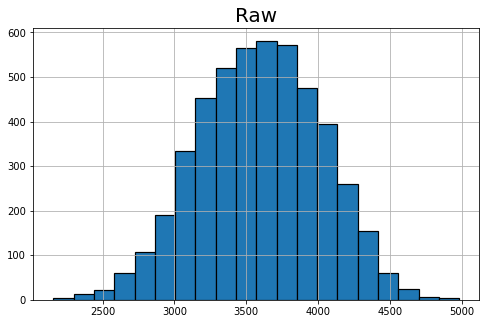

In [ ]:
def plot_hist(feature, title):
    plt.figure(figsize=(8, 5));
    plt.hist(feature, bins=20, edgecolor='black', linewidth=1.2);
    plt.title(title, fontsize=20);
    #ax.tick_params(axis='both', which='major', labelsize=18);
    plt.grid(True);

plot_hist(X_train['Amount'], "Raw");

I use the MinMax Scaler for practice... I honestly found "Amount" was good as is.

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(X_train[['Amount']])

X_train['Amount_MinMax'] = scaler.transform(X_train[['Amount']])   

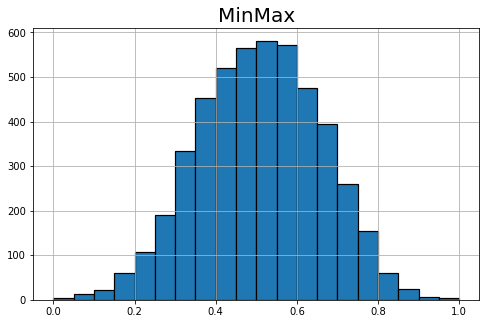

In [ ]:
plot_hist(X_train['Amount_MinMax'], "MinMax");

I want to see what my data is looking like now... Looks good!

In [ ]:
X_train['Index'] = X_train.index
X_train.head()

,PreviousDefault,NumberPets,PreviousAccounts,ResidenceDuration,Amount,Married,Duration,Sex_F,Sex_M,Purpose_Business,Purpose_Education,Purpose_Household,Purpose_NewCar,Purpose_Other,Purpose_Repair,Purpose_UsedCar,Purpose_Vacation,Age,Amount_MinMax,Index
3897,0,2,0,2,3329,0,12,0,1,0,0,1,0,0,0,0,0,52,0.414660,3897
5628,0,0,2,2,2996,0,36,1,0,0,0,1,0,0,0,0,0,58,0.296742,5628
1756,0,2,0,3,2470,0,24,1,0,0,0,0,1,0,0,0,0,47,0.110482,1756
2346,0,2,1,2,3745,0,30,1,0,0,0,0,0,0,0,1,0,45,0.561969,2346
2996,0,0,1,3,3549,0,36,0,1,0,0,0,0,0,0,0,1,45,0.492564,2996


I want to take it a step further and use FeatureTools to get Aggregate features. However I think I used it incorrectly! I left them here so I can play with it and see what went wrong...

In [ ]:
import featuretools as ft

es = es = ft.EntitySet(id="unclesteve")
es

/usr/local/lib/python3.7/dist-packages/woodwork/__init__.py:23: FutureWarning: Woodwork may not support Python 3.7 in next non-bugfix release.
  "Woodwork may not support Python 3.7 in next non-bugfix release.", FutureWarning
/usr/local/lib/python3.7/dist-packages/featuretools/__init__.py:67: FutureWarning: Featuretools may not support Python 3.7 in next non-bugfix release.
  FutureWarning,


Entityset: unclesteve
  DataFrames:
  Relationships:
    No relationships

In [ ]:
from woodwork.logical_types import Categorical, PostalCode

es = es.add_dataframe(
    dataframe_name="X_train",
    dataframe=X_train,
    index="Index",
    logical_types={
        "PreviousDefault": Categorical,
        "Married": Categorical,
        "Sex_F": Categorical,
        "Sex_M": Categorical,
        "Purpose_Business": Categorical,
        "Purpose_Education": Categorical,
        "Purpose_Household": Categorical,
        "Purpose_NewCar": Categorical,
        "Purpose_Other": Categorical,
        "Purpose_Repair": Categorical,
        "Purpose_UsedCar": Categorical,
        "Purpose_Vacation": Categorical,
        },
)

es

Entityset: unclesteve
  DataFrames:
    X_train [Rows: 4800, Columns: 20]
  Relationships:
    No relationships

In [ ]:
es["X_train"].ww.schema

,Logical Type,Semantic Tag(s)
Column,,
PreviousDefault,Categorical,['category']
NumberPets,Integer,['numeric']
PreviousAccounts,Integer,['numeric']
ResidenceDuration,Integer,['numeric']
Amount,Integer,['numeric']
Married,Categorical,['category']
Duration,Integer,['numeric']
Sex_F,Categorical,['category']
Sex_M,Categorical,['category']


In [ ]:
feature_matrix, feature_defs = ft.dfs(entityset=es, 
                                      target_dataframe_name="X_train", 
                                      agg_primitives=["count", "sum"], 
                                      where_primitives=["count", "sum"],
                                      max_depth=2,
                                      verbose=True)

feature_matrix

/usr/local/lib/python3.7/dist-packages/featuretools/synthesis/deep_feature_synthesis.py:162: UserWarning: Only one dataframe in entityset, changing max_depth to 1 since deeper features cannot be created
  "Only one dataframe in entityset, changing max_depth to "
/usr/local/lib/python3.7/dist-packages/featuretools/synthesis/dfs.py:321: UnusedPrimitiveWarning: Some specified primitives were not used during DFS:
  agg_primitives: ['count', 'sum']
  where_primitives: ['count', 'sum']
This may be caused by a using a value of max_depth that is too small, not setting interesting values, or it may indicate no compatible columns for the primitive were found in the data. If the DFS call contained multiple instances of a primitive in the list above, none of them were used.
  warnings.warn(warning_msg, UnusedPrimitiveWarning)


Built 19 features
Elapsed: 00:00 | Progress: 100%|██████████


,PreviousDefault,NumberPets,PreviousAccounts,ResidenceDuration,Amount,Married,Duration,Sex_F,Sex_M,Purpose_Business,Purpose_Education,Purpose_Household,Purpose_NewCar,Purpose_Other,Purpose_Repair,Purpose_UsedCar,Purpose_Vacation,Age,Amount_MinMax
Index,,,,,,,,,,,,,,,,,,,
3897,0,2,0,2,3329,0,12,0,1,0,0,1,0,0,0,0,0,52,0.414660
5628,0,0,2,2,2996,0,36,1,0,0,0,1,0,0,0,0,0,58,0.296742
1756,0,2,0,3,2470,0,24,1,0,0,0,0,1,0,0,0,0,47,0.110482
2346,0,2,1,2,3745,0,30,1,0,0,0,0,0,0,0,1,0,45,0.561969
2996,0,0,1,3,3549,0,36,0,1,0,0,0,0,0,0,0,1,45,0.492564
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3772,0,0,1,1,3607,1,24,1,0,0,0,0,1,0,0,0,0,49,0.513102
5191,0,2,1,0,3186,0,30,1,0,0,0,0,1,0,0,0,0,48,0.364023
5226,0,2,1,3,2387,1,36,1,0,1,0,0,0,0,0,0,0,53,0.081091


In [ ]:
list(feature_matrix)

['PreviousDefault',
 'NumberPets',
 'PreviousAccounts',
 'ResidenceDuration',
 'Amount',
 'Married',
 'Duration',
 'Sex_F',
 'Sex_M',
 'Purpose_Business',
 'Purpose_Education',
 'Purpose_Household',
 'Purpose_NewCar',
 'Purpose_Other',
 'Purpose_Repair',
 'Purpose_UsedCar',
 'Purpose_Vacation',
 'Age',
 'Amount_MinMax']

In [ ]:
X_train = X_train.drop('Index', axis = 1)
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4800 entries, 3897 to 860
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   PreviousDefault    4800 non-null   category
 1   NumberPets         4800 non-null   int64   
 2   PreviousAccounts   4800 non-null   int64   
 3   ResidenceDuration  4800 non-null   int64   
 4   Amount             4800 non-null   int64   
 5   Married            4800 non-null   category
 6   Duration           4800 non-null   int64   
 7   Sex_F              4800 non-null   category
 8   Sex_M              4800 non-null   category
 9   Purpose_Business   4800 non-null   category
 10  Purpose_Education  4800 non-null   category
 11  Purpose_Household  4800 non-null   category
 12  Purpose_NewCar     4800 non-null   category
 13  Purpose_Other      4800 non-null   category
 14  Purpose_Repair     4800 non-null   category
 15  Purpose_UsedCar    4800 non-null   category
 16  Purp

I was expecting to see more features here... but none appeared!

In [ ]:
clf = RandomForestClassifier(n_estimators=100, criterion='entropy', max_depth=None, 
                             min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, 
                             max_features='sqrt', max_leaf_nodes=None, min_impurity_decrease=0.0, 
                             bootstrap=True, oob_score=False, n_jobs=None, random_state=666, verbose=0, 
                             warm_start=False, class_weight=None, ccp_alpha=0.0, max_samples=None)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_train)

scores = cross_val_score(clf, X_train, y_train, cv=10, scoring="f1_macro")
scores2 = cross_val_score(clf, X_train, y_train, cv=10, scoring="precision")

with np.printoptions(formatter={'float': '{: 0.3f}'.format}):
  print("CV scores: {}".format(scores))
  print("Estimated F1 Score: {:0.3f} +/- {:0.2f}".format(np.mean(scores), np.std(scores)))
  print("Estimated Precision Score: {:0.3f} +/- {:0.2f}".format(np.mean(scores2), np.std(scores2)))

CV scores: [ 0.800  0.765  0.757  0.714  0.789  0.809  0.771  0.785  0.723  0.802]
Estimated F1 Score: 0.772 +/- 0.03
Estimated Precision Score: 0.700 +/- 0.06


After feature engineering, my F1 Score rose from 0.621 to 0.772 and Precision went up from 0.448 to 0.700! A significant improvement!!

## 2.3: Feature selection

In [ ]:
from sklearn.feature_selection import SelectKBest, chi2

sel = SelectKBest(chi2, k=17)
sel = sel.fit(X_train, y_train)

X_train_new = sel.transform(X_train)

X_train_new.shape

(4800, 17)

In [ ]:
clf.fit(X_train_new, y_train)
y_pred = clf.predict(X_train_new)

scores = cross_val_score(clf, X_train_new, y_train, cv=10, scoring="f1_macro")
scores2 = cross_val_score(clf, X_train_new, y_train, cv=10, scoring="precision")

with np.printoptions(formatter={'float': '{: 0.3f}'.format}):
  print("CV scores: {}".format(scores))
  print("Estimated F1 Score: {:0.3f} +/- {:0.2f}".format(np.mean(scores), np.std(scores)))
  print("Estimated Precision Score: {:0.3f} +/- {:0.2f}".format(np.mean(scores2), np.std(scores2)))

CV scores: [ 0.815  0.742  0.760  0.716  0.792  0.808  0.766  0.805  0.723  0.809]
Estimated F1 Score: 0.774 +/- 0.04
Estimated Precision Score: 0.702 +/- 0.06


I test K from 13 to 18, k = 17 yielded the best result with F1 rising to .774 (+ 0.002) and Precision rising to .702 (+ 0.002)

## 2.4: Hyperparameter tuning

In [ ]:
from sklearn.model_selection import GridSearchCV

clf = RandomForestClassifier(min_weight_fraction_leaf=0.0, max_leaf_nodes=None, min_impurity_decrease=0.0, 
                             oob_score=False, n_jobs=None, random_state=666, verbose=0, 
                             warm_start=False, class_weight=None, ccp_alpha=0.0, max_samples=None)

params = {'criterion': ('gini', 'entropy'), 
          'n_estimators': [50, 100],
          'max_depth': [2, 5],
          'min_samples_split': [2,3],
          'min_samples_leaf': [1, 5],
          'max_features': ['sqrt', 'log2'],
          'bootstrap': ['True','False']
          }

search = GridSearchCV(clf, params, scoring='f1_macro', cv=10, verbose=1)
search = search.fit(X_train, y_train)

Fitting 10 folds for each of 128 candidates, totalling 1280 fits


In [ ]:
search.best_params_

{'bootstrap': 'True',
 'criterion': 'entropy',
 'max_depth': 5,
 'max_features': 'sqrt',
 'min_samples_leaf': 5,
 'min_samples_split': 2,
 'n_estimators': 100}

In [ ]:
clf = RandomForestClassifier(n_estimators=100, criterion='entropy', max_depth=5, 
                             min_samples_split=2, min_samples_leaf=5, min_weight_fraction_leaf=0.0, 
                             max_features='sqrt', max_leaf_nodes=None, min_impurity_decrease=0.0, 
                             bootstrap=True, oob_score=False, n_jobs=None, random_state=666, verbose=0, 
                             warm_start=False, class_weight=None, ccp_alpha=0.0, max_samples=None)

In [ ]:
scores = cross_val_score(clf, X_train_new, y_train, cv=10, scoring="f1_macro")
scores2 = cross_val_score(clf, X_train_new, y_train, cv=10, scoring="precision")

with np.printoptions(formatter={'float': '{: 0.3f}'.format}):
  print("CV scores: {}".format(scores))
  print("Estimated F1 Score: {:0.3f} +/- {:0.2f}".format(np.mean(scores), np.std(scores)))
  print("Estimated Precision Score: {:0.3f} +/- {:0.2f}".format(np.mean(scores2), np.std(scores2)))


CV scores: [ 0.791  0.738  0.744  0.700  0.772  0.786  0.754  0.800  0.725  0.747]
Estimated F1 Score: 0.756 +/- 0.03
Estimated Precision Score: 0.754 +/- 0.06


So I got my model to around 0.75 for both F1 and Precision!

The goal of this example is not to get the best result, but to show a process. I won't do any more work, but if I had time: I would have tried additional algorithms, hyperparameter tuned for much longer, and definitely put more effort into getting FeatureTools to work! I definitely think I could have gotten over the 0.8!

Now that clf is well-trained, I can finally touch the test splits!

## 3.5: Performance estimation

In [ ]:
X_train.head()

,PreviousDefault,NumberPets,PreviousAccounts,ResidenceDuration,Amount,Married,Duration,Sex_F,Sex_M,Purpose_Business,Purpose_Education,Purpose_Household,Purpose_NewCar,Purpose_Other,Purpose_Repair,Purpose_UsedCar,Purpose_Vacation,Age,Amount_MinMax
3897,0,2,0,2,3329,0,12,0,1,0,0,1,0,0,0,0,0,52,0.414660
5628,0,0,2,2,2996,0,36,1,0,0,0,1,0,0,0,0,0,58,0.296742
1756,0,2,0,3,2470,0,24,1,0,0,0,0,1,0,0,0,0,47,0.110482
2346,0,2,1,2,3745,0,30,1,0,0,0,0,0,0,0,1,0,45,0.561969
2996,0,0,1,3,3549,0,36,0,1,0,0,0,0,0,0,0,1,45,0.492564


In [ ]:
X_test.head()

,UserID,Sex,PreviousDefault,FirstName,LastName,NumberPets,PreviousAccounts,ResidenceDuration,Street,LicensePlate,Amount,Married,Duration,City,Purpose,DateOfBirth
1782,435-05-4551,F,0,Tanya,Conner,1,1,3,4508 Crystal Rue Suite 173,HCY 571,3773,0,36,North Judithbury,NewCar,1970-10-15
3917,541-06-3756,F,0,Tammy,Brennan,0,0,3,6932 Stevenson Falls Suite 044,52A TE2,3412,0,24,Lake Roberto,UsedCar,1963-09-01
221,680-68-0713,F,0,Joanna,Johnson,2,2,0,833 Dunn Road,EWW 069,4146,0,24,West Michael,NewCar,1970-12-19
2135,853-48-9552,M,0,Nicholas,Richardson,2,1,1,81683 Hernandez Mission Suite 210,QPF-7410,3608,1,30,East Jessetown,UsedCar,1963-08-05
5224,147-43-5023,F,0,Megan,Jones,2,1,1,383 Wong Ferry,V 896714,2947,1,24,North Judithbury,NewCar,1978-05-11


In [ ]:
X_test = X_test.drop(['UserID','FirstName','LastName', 'Street','LicensePlate','City'], axis = 1)
X_test = pd.get_dummies(X_test, columns = ['Sex','Purpose'])
X_test['DateOfBirth'] = pd.to_datetime(X_test['DateOfBirth'])
X_test['Age'] = X_test['DateOfBirth'].apply(age)
X_test = X_test.drop(['DateOfBirth'], axis = 1)
X_test['Amount_MinMax'] = scaler.transform(X_test[['Amount']])   
X_test_new = sel.transform(X_test)

In [ ]:
X_test.head()

,PreviousDefault,NumberPets,PreviousAccounts,ResidenceDuration,Amount,Married,Duration,Sex_F,Sex_M,Purpose_Business,Purpose_Education,Purpose_Household,Purpose_NewCar,Purpose_Other,Purpose_Repair,Purpose_UsedCar,Purpose_Vacation,Age,Amount_MinMax
1782,0,1,1,3,3773,0,36,1,0,0,0,0,1,0,0,0,0,51,0.571884
3917,0,0,0,3,3412,0,24,1,0,0,0,0,0,0,0,1,0,58,0.444051
221,0,2,2,0,4146,0,24,1,0,0,0,0,1,0,0,0,0,51,0.703966
2135,0,2,1,1,3608,1,30,0,1,0,0,0,0,0,0,1,0,58,0.513456
5224,0,2,1,1,2947,1,24,1,0,0,0,0,1,0,0,0,0,44,0.279391


In [ ]:
scores = cross_val_score(clf, X_test_new, y_test, cv=10, scoring="f1_macro")
scores2 = cross_val_score(clf, X_test_new, y_test, cv=10, scoring="precision")

with np.printoptions(formatter={'float': '{: 0.3f}'.format}):
  print("CV scores: {}".format(scores))
  print("Estimated F1 Score: {:0.3f} +/- {:0.2f}".format(np.mean(scores), np.std(scores)))
  print("Estimated Precision Score: {:0.3f} +/- {:0.2f}".format(np.mean(scores2), np.std(scores2)))

CV scores: [ 0.820  0.820  0.837  0.801  0.832  0.850  0.673  0.801  0.809  0.804]
Estimated F1 Score: 0.805 +/- 0.05
Estimated Precision Score: 0.757 +/- 0.10


In [ ]:
clf.fit(X_test_new, y_test)
y_pred = clf.predict(X_test_new)

In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, y_pred)

array([[961,  30],
       [ 84, 125]])

Not bad! F1 Score is 0.805 and Precision is 0.757. I wish precision would be higher because it means we're giving loans to a significant population who are at risk.